In [132]:
import os
import sys
import re
import pathlib
sys.path.append('/Volumes/Samsung_T5/saturnx/')
import saturnx as sx
from saturnx.utils.xray import convert_time
from saturnx.utils.fits import get_basic_info
from saturnx.utils.pdf import pdf_page
from saturnx.utils.my_functions import yesno, list_items, chunks
#from sx.xray import convert_time
#from sx.nicer_functions import check_nicer_data, check_nicer_filtering
#from sx.fits import get_basic_info
import pandas as pd
import numpy as np
from PyPDF2 import PdfFileMerger, PdfFileReader
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
def make_pdf_table(df,output_name,title='Data folders and files',value=False,color='red',vertical=False):
    '''
    make a PDF from a dataframe highlighting specified values
    '''
    if not isinstance(value,list):
        value = [value]
    if not '.pdf' in output_name:
        output_name += '.pdf'
        
    if vertical:
        fig, ax =plt.subplots(figsize=(8.3,11.7))
    else:
        fig, ax =plt.subplots(figsize=(11.7,8.3))
    ax.set_title(title)
    ax.axis('off')
    table = ax.table(cellText=df.values, rowLabels=df.index, cellLoc='center',
                     colLabels=df.columns, loc='center')
    for i in range(-1,len(df.columns)):
        for j in range(1,len(df)+1):
            cell = table[j,i]
            text = cell.get_text()
            if text.get_text() == 'False':
                cell.set_facecolor('red')

                ax.add_patch(cell)

    pp = PdfPages(output_name)
    pp.savefig(fig, bbox_inches='tight')
    pp.close()         

In [62]:
def df_to_pdf(df,output_name,*args,**kwargs):
    '''
    Converts a pandas dataframe in html and pdf table keeping the applied style
    
    DESCRIPTION
    -----------
    Compared to my previous version of the same program, this one not only keeps
    the style you apply to the dataframe, but, when converting the html table top pdf,
    splits long tables in different pdf pages, that is quite convenient for readability
    
    PARAMETERS
    ----------
    df: pandas.DataFrame
    output_name: str
        output name for the html and pdf table (without extension)
    *args and **kwargs are fed to style.apply()
    
    HISTORY
    -------
    2022 02 16, Stefano Rapisarda (Uppsala), creation date
    '''
    
    # Applying style to the dataframe
    style1 = df.style.apply(*args,**kwargs)
    
    # Rendering the html (with CSS style) in a string
    my_html_string = style1.render()
    
    # ADD !important TO ALL THE BACKGROUND STATEMENTS
    # This is for having the background correctly transfered to the PDF
    # locate all of them:
    p = re.compile('background: (.*);')
    unique_bg_statements = list(set(p.findall(my_html_string)))
    for bs in unique_bg_statements:
        my_html_string = my_html_string.replace(bs,bs+" !important") #add !important
        
    # Adding border to the table
    p2 = re.compile('<table')
    unique_table_statement = list(set(p2.findall(my_html_string)))
    for bs in unique_table_statement:
        my_html_string = my_html_string.replace(bs,bs+' border="1" ')
    
    # Making html and pdf file
    with open(output_name+'.html','w') as outfile:
        for line in my_html_string.split('\n'):
            outfile.write(line)
            
    options = {
    'page-size': 'A4'
    }
    with open(output_name+'.html') as f:
        pdfkit.from_file(f,output_name+'.pdf',options=options)
    

In [3]:
def highlight(df,value=False,color='red'):
    '''
    highlight value
    '''
    if not isinstance(value,list):
        value = [value]
    
    tot_mask = df == value[0]
    for i in range(1,len(value)):
        mask = df == value[i]
        tot_mask = tot_mask & mask
    
    return [f'background-color: {color}' if i else '' for i in tot_mask]

In [185]:
data_dir = pathlib.Path('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/')
obs_ids = [obs_id for obs_id in next(os.walk(data_dir))[1] if obs_id.isdigit()]
obs_ids = sorted(obs_ids)
n_obs = len(obs_ids)
print(n_obs)

372


# Checking data folders and files

Creating a pandas data frame (check_obs_df) having obs_ID as indices and folder and file names as columns

In [5]:
df_name = 'check_obs_df.pkl'
reset = yesno('Reset check_obd dataframe?')
if not os.path.isfile(df_name) or reset:
    df_list = []
    for obs_id in obs_ids:
        #print(obs_id)
        file_check, files = sx.check_nicer_data(data_dir/obs_id)
        df = pd.DataFrame(file_check,index=[obs_id])
        df_list += [df]
    check_obs_df = pd.concat(df_list)
    check_obs_df.to_pickle(df_name)
else:
    check_obs_df = pd.read_pickle(df_name)

Reset check_obd dataframe?(Yes/No) yes


- att: Attitude file;
- orb: Orbital file;
- cat: Cat file;
- mkf: make filter file;
- mkf2: make filter file 2 (output of niprefilter2, necessary for background estimation via nicer_bkg_estimator);
- mkf3: output og nicer_bkg_estimator procedure (compare to mkf2, it inclused the kp index);
- uf: unscreened and uncalibrated event files (starting point for data reduction, Level1), one for each MPU (7);
- ufa: unscreened and calibrated event files, all the MPUs have been merged into one file (Level2);
- cl: screened and calibrated event files (Lebel2a);
- cl_bdc: screened and calibrated event files corrected for bad or noisy detectors (default is 11, 14, 20, 22, 34, 60). Noisy detectors are excluded using nifpmsel and operations are logged in nifpmsel.log;
- cl_bdc_bc: screened and calibrated event files corrected for bad or noisy detectors and barycentric corrected. Barycentric correction is perfomed by barycorr and operations are logged in barycorr.log;
- spectrum is the energy spectrum computed by run_xselect (xselect);
- bkg_spectrum is the background energy spectrum computed via the nicer background estimator (mk_bkg_spec_evt);
- grp_spectrum is the energy spectrum with bins grouped in minimum 25 count energy bins;
- 3C50_spectrum is the energy spectrum computed using nibackgen3c50;
- 3c50_bkg is the background energy spectrum computed using nibackgen3c50;

In [206]:
check_obs_df.style.apply(highlight)

,att,orb,cat,mkf,mkf2,mkf3,uf,ufa,cl,cl_bdc,cl_bdc_bc,spectrum,bkg_spectrum,grp_spectrum,3C50_spectrum,3C50_bkg,arf,rmf,lis
1200120101,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True
1200120102,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1200120103,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1200120104,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1200120105,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1200120106,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1200120107,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1200120108,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1200120109,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1200120110,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [63]:
df_to_pdf(check_obs_df,'check_obs_df',highlight)
pdf_plots += ['check_obs_df']

# Check observation characteristics

In [8]:
file_dict = {}
for obs_id in obs_ids:
    files_check,file_names = sx.check_nicer_data(data_dir/obs_id)    
    file_dict[obs_id]=file_names

In [9]:
file_dict[obs_ids[0]]

{'att': PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/auxil/ni1200120101.att.gz'),
 'orb': PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/auxil/ni1200120101.orb.gz'),
 'cat': PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/auxil/ni1200120101.cat'),
 'mkf': PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/auxil/ni1200120101.mkf'),
 'mkf2': PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/auxil/ni1200120101.mkf2'),
 'mkf3': PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/auxil/ni1200120101.mkf3'),
 'uf': [PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu0_uf.evt.gz'),
  PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu1_uf.evt.gz'),
  PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu2_uf.evt.gz'),
  PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/12001201

Creating a pandas data frame (check_obs_df) having obs_ID as indices and some meaningfull header keywords as columns

In [11]:
df_name = 'info_obs_df.pkl'
reset = yesno('Reset info_obs dataframe?')
if not os.path.isfile(df_name) or reset:
    df_list = []
    info_obs_dict = {}
    for obs_id in obs_ids:
        if check_obs_df.loc[obs_id].cl:
            info = get_basic_info(file_dict[obs_id]['cl_bdc'],ext=1)
            info_obs_dict[obs_id] = info
            df = pd.DataFrame(info,index=[obs_id])
            df_list += [df]
    info_obs_df = pd.concat(df_list)
    info_obs_df.to_pickle(df_name)
else:
    info_obs_df = pd.read_pickle(df_name)

Reset info_obs dataframe?(Yes/No) y


In [77]:
file_dict[obs_ids[0]]['uf']

[PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu0_uf.evt.gz'),
 PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu1_uf.evt.gz'),
 PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu2_uf.evt.gz'),
 PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu3_uf.evt.gz'),
 PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu4_uf.evt.gz'),
 PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu5_uf.evt.gz'),
 PosixPath('/Volumes/BigBoy/NICER_data/MAXI_J1820+070/1200120101/xti/event_uf/ni1200120101_0mpu6_uf.evt.gz')]

The previous loop jumped over obs. ID where a cleaned event file has not been computed. The following loop adds back all the obs IDs

In [78]:
for obs_id in obs_ids:
    if not obs_id in info_obs_df.index:
        print('Adding obs. ID {}'.format(obs_id))
        if len(file_dict[obs_id]['uf']) != 0:
            info = get_basic_info(file_dict[obs_id]['uf'][0],ext=1)
        else:
            basic_keys = ['OBJECT','TELESCOP','INSTRUME','OBS_ID','RA_OBJ','DEC_OBJ',
              'CREATOR','DATE','SOFTVER','CALDBVER','GCALFILE']

            time_keys = ['DATE-OBS','DATE-END','TSTART','TSTOP',
             'MJDREF','MJDREFI','MJDREFF','TIMEZERO','LEAPINIT','CLOCKAPP',
             'TIMEZERO','ONTIME','EXPOSURE','NAXIS2','TIMESYS']
            
            info = {key:False for key in basic_keys+time_keys}
            
        info_obs_df.loc[obs_id] = info
info_obs_df.sort_index(axis = 0, inplace=True)

Adding obs. ID 1200120129
Adding obs. ID 1200120197
Adding obs. ID 1200120221
Adding obs. ID 1200120223


Adding obs. ID 1200120306


Adding obs. ID 2200120403
Adding obs. ID 4200120402


In [94]:
info_obs_df.style.apply(highlight,value=0)

,OBJECT,TELESCOP,INSTRUME,OBS_ID,RA_OBJ,DEC_OBJ,CREATOR,DATE,SOFTVER,CALDBVER,GCALFILE,DATE-OBS,DATE-END,TSTART,TSTOP,MJDREF,MJDREFI,MJDREFF,TIMEZERO,LEAPINIT,CLOCKAPP,ONTIME,EXPOSURE,NAXIS2,TIMESYS
1200120101,MAXI_J1820+070,NICER,XTI,1200120101,275.091400,7.185300,nicertimecal1 1.5,2018-03-16T22:44:56,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-12T13:51:20,2018-03-12T22:00:20,132328360.000000,132357619.000000,None,56658,0.000778,-1.000000,2,True,7149.000000,7149.000000,5919098,TT
1200120102,MAXI_J1820+070,NICER,XTI,1200120102,275.091400,7.185300,nicertimecal1 1.5,2018-03-19T00:07:44,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-13T14:37:20,2018-03-13T22:43:12,132417765.000000,132446576.000000,None,56658,0.000778,-1.000000,2,True,5857.000000,5857.000000,8703653,TT
1200120103,MAXI_J1820+070,NICER,XTI,1200120103,275.091400,7.185300,nicertimecal1 1.5,2018-03-19T00:19:39,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-13T23:56:12,2018-03-14T23:25:52,132451058.000000,132535536.000000,None,56658,0.000778,-1.000000,2,True,11081.000000,11081.000000,23749265,TT
1200120104,MAXI_J1820+070,NICER,XTI,1200120104,275.091400,7.185300,nicertimecal1 1.5,2018-03-19T20:21:48,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-15T00:36:04,2018-03-15T21:02:52,132540014.000000,132613372.000000,None,56658,0.000778,-1.000000,2,True,7380.000000,7380.000000,24269263,TT
1200120105,MAXI_J1820+070,NICER,XTI,1200120105,275.091400,7.185300,nicertimecal1 1.5,2018-03-20T20:28:45,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-16T04:27:58,2018-03-16T20:00:00,132640198.000000,132696001.000000,None,56658,0.000778,-1.000000,2,True,3058.000000,3058.000000,16449795,TT
1200120106,MAXI_J1820+070,NICER,XTI,1200120106,275.091400,7.185300,nicertimecal1 1.5,2018-03-26T08:48:53,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-21T09:15:20,2018-03-21T23:15:40,133089461.000000,133139741.000000,None,56658,0.000778,-1.000000,2,True,5485.000000,5485.000000,108763329,TT
1200120107,MAXI_J1820+070,NICER,XTI,1200120107,275.091400,7.185300,nicertimecal1 1.5,2018-04-14T04:07:00,Hea_06Mar2018_V6.23_NICER_2018-04-06_V003b,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-22T00:34:59,2018-03-22T22:30:00,133144634.000000,133223401.000000,None,56658,0.000778,-1.000000,2,True,18418.995071,18418.995071,355008844,TT
1200120108,MAXI_J1820+070,NICER,XTI,1200120108,275.091400,7.185300,nicertimecal1 1.5,2018-03-28T01:53:04,Hea_10Oct2017_V6.22.1_NICER_2018-03-01_V003,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-22T23:43:18,2018-03-23T06:28:02,133227923.000000,133251852.000000,None,56658,0.000778,-1.000000,2,True,6980.000000,6980.000000,118696440,TT
1200120109,MAXI_J1820+070,NICER,XTI,1200120109,275.091400,7.185300,nicertimecal1 1.5,2018-04-16T22:32:58,Hea_06Mar2018_V6.23_NICER_2018-04-13_V004,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-24T00:36:00,2018-03-24T22:32:03,133317708.000000,133396324.000000,None,56658,0.000778,-1.000000,2,True,13386.999761,13386.999761,274166035,TT
1200120110,MAXI_J1820+070,NICER,XTI,1200120110,275.091400,7.185300,nicertimecal1 1.5,2018-04-14T09:18:12,Hea_06Mar2018_V6.23_NICER_2018-04-06_V003b,xti20210707,nixtiflightpi20170601v007.fits[1],2018-03-24T23:35:38,2018-03-25T23:13:49,133400209.000000,133485230.000000,None,56658,0.000778,-1.000000,2,True,23120.995244,23120.995244,470954100,TT


In [95]:
df_to_pdf(info_obs_df[['DATE-OBS','DATE-END','ONTIME','EXPOSURE','NAXIS2']],'info_obs_df',func=highlight,value=0)

Total duration of the observations in ks

In [15]:
info_obs_df['ONTIME'].sum()/1000

969.4342924920022

# Checking photon filtering

In data reduction some of the photons are filtered out. Filtering criteria are applied making first a make filter file (mkf), splitting events in 1s GTIs and indicating which GTI satisfies the filtering criteria. Comparing unfiltered and filtered GTIs it is possible to estimate how many photons have been filtered by each filtering criterium. The amount of filtered photons should correspond to the difference between uf and cl events

In [42]:
df_list = []
for obs_id in obs_ids:
    print('Processing obs. ID {}'.format(obs_id))
    if check_obs_df.loc[obs_id].mkf:
        filter_file = list_items(data_dir/obs_id/'auxil',itype='file',include_and=['mkf'],exclude_and=['mkf2','mkf3'])[0]
        info = sx.check_nicer_filtering(filter_file)
        df = pd.DataFrame(info,index=[obs_id])
        df_list += [df]
filter_obs_df_cons = pd.concat(df_list)

Processing obs. ID 1200120101
INFO: 2022-02-16 15:07:51.557390: There are 9237 1s rows (time bins)
Processing obs. ID 1200120102
INFO: 2022-02-16 15:07:52.750595: There are 8259 1s rows (time bins)
Processing obs. ID 1200120103
INFO: 2022-02-16 15:07:54.718361: There are 14369 1s rows (time bins)
Processing obs. ID 1200120104
INFO: 2022-02-16 15:07:56.017695: There are 8979 1s rows (time bins)
Processing obs. ID 1200120105
INFO: 2022-02-16 15:07:56.802925: There are 5093 1s rows (time bins)
Processing obs. ID 1200120106
INFO: 2022-02-16 15:07:57.821672: There are 7006 1s rows (time bins)
Processing obs. ID 1200120107
INFO: 2022-02-16 15:08:00.857043: There are 21776 1s rows (time bins)
Processing obs. ID 1200120108
INFO: 2022-02-16 15:08:02.085989: There are 7995 1s rows (time bins)
Processing obs. ID 1200120109
INFO: 2022-02-16 15:08:03.992328: There are 15429 1s rows (time bins)
Processing obs. ID 1200120110
INFO: 2022-02-16 15:08:07.234979: There are 25622 1s rows (time bins)
Proces

INFO: 2022-02-16 15:09:06.328566: There are 1026 1s rows (time bins)
Processing obs. ID 1200120185
INFO: 2022-02-16 15:09:06.863037: There are 3259 1s rows (time bins)
Processing obs. ID 1200120186
INFO: 2022-02-16 15:09:07.428056: There are 3210 1s rows (time bins)
Processing obs. ID 1200120187
INFO: 2022-02-16 15:09:07.794173: There are 1796 1s rows (time bins)
Processing obs. ID 1200120188
INFO: 2022-02-16 15:09:08.187613: There are 2096 1s rows (time bins)
Processing obs. ID 1200120189
INFO: 2022-02-16 15:09:10.929361: There are 20360 1s rows (time bins)
Processing obs. ID 1200120190
INFO: 2022-02-16 15:09:11.693367: There are 4390 1s rows (time bins)
Processing obs. ID 1200120191
INFO: 2022-02-16 15:09:11.996704: There are 1237 1s rows (time bins)
Processing obs. ID 1200120192
INFO: 2022-02-16 15:09:12.305896: There are 1253 1s rows (time bins)
Processing obs. ID 1200120193
INFO: 2022-02-16 15:09:12.531528: There are 826 1s rows (time bins)
Processing obs. ID 1200120194
INFO: 2022

INFO: 2022-02-16 15:10:01.332070: There are 5094 1s rows (time bins)
Processing obs. ID 1200120269
INFO: 2022-02-16 15:10:01.962817: There are 3934 1s rows (time bins)
Processing obs. ID 1200120270
INFO: 2022-02-16 15:10:02.405013: There are 2475 1s rows (time bins)
Processing obs. ID 1200120271
INFO: 2022-02-16 15:10:02.675735: There are 1017 1s rows (time bins)
Processing obs. ID 1200120272
INFO: 2022-02-16 15:10:02.877433: There are 476 1s rows (time bins)
Processing obs. ID 1200120273
INFO: 2022-02-16 15:10:03.199315: There are 1585 1s rows (time bins)
Processing obs. ID 1200120274
INFO: 2022-02-16 15:10:03.824774: There are 3895 1s rows (time bins)
Processing obs. ID 1200120275
INFO: 2022-02-16 15:10:04.836070: There are 6416 1s rows (time bins)
Processing obs. ID 1200120276
INFO: 2022-02-16 15:10:05.614073: There are 4543 1s rows (time bins)
Processing obs. ID 1200120277
INFO: 2022-02-16 15:10:06.059990: There are 2415 1s rows (time bins)
Processing obs. ID 1200120278
INFO: 2022-

INFO: 2022-02-16 15:10:51.488951: There are 2967 1s rows (time bins)
Processing obs. ID 2200120333
INFO: 2022-02-16 15:10:51.793670: There are 1337 1s rows (time bins)
Processing obs. ID 2200120334
INFO: 2022-02-16 15:10:51.997677: There are 426 1s rows (time bins)
Processing obs. ID 2200120335
INFO: 2022-02-16 15:10:52.602338: There are 3556 1s rows (time bins)
Processing obs. ID 2200120336
INFO: 2022-02-16 15:10:53.303782: There are 4458 1s rows (time bins)
Processing obs. ID 2200120337
INFO: 2022-02-16 15:10:53.582427: There are 1105 1s rows (time bins)
Processing obs. ID 2200120338
INFO: 2022-02-16 15:10:53.792919: There are 538 1s rows (time bins)
Processing obs. ID 2200120339
INFO: 2022-02-16 15:10:53.964262: There are 283 1s rows (time bins)
Processing obs. ID 2200120340
INFO: 2022-02-16 15:10:54.159640: There are 370 1s rows (time bins)
Processing obs. ID 2200120341
INFO: 2022-02-16 15:10:54.384133: There are 797 1s rows (time bins)
Processing obs. ID 2200120342
INFO: 2022-02-1

INFO: 2022-02-16 15:11:29.230006: There are 4935 1s rows (time bins)
Processing obs. ID 3200120409
INFO: 2022-02-16 15:11:29.524222: There are 1137 1s rows (time bins)
Processing obs. ID 3200120410
INFO: 2022-02-16 15:11:30.014513: There are 2657 1s rows (time bins)
Processing obs. ID 3200120411
INFO: 2022-02-16 15:11:30.399780: There are 1826 1s rows (time bins)
Processing obs. ID 3200120412
INFO: 2022-02-16 15:11:30.863813: There are 1303 1s rows (time bins)
Processing obs. ID 3200120413
INFO: 2022-02-16 15:11:31.117956: There are 306 1s rows (time bins)
Processing obs. ID 3200120414
INFO: 2022-02-16 15:11:31.553975: There are 2384 1s rows (time bins)
Processing obs. ID 3200120415
INFO: 2022-02-16 15:11:31.940645: There are 2007 1s rows (time bins)
Processing obs. ID 3200120416
INFO: 2022-02-16 15:11:32.123111: There are 290 1s rows (time bins)
Processing obs. ID 3200120417
INFO: 2022-02-16 15:11:32.387505: There are 963 1s rows (time bins)
Processing obs. ID 3200120418
INFO: 2022-02

In [35]:
filter_obs_df_cons.style.apply(highlight,value=100)

,nicersaafilt,saafilt,trackfilt,ang_dist,st_valid,elv,br_earth,min_fpm,cor_range,underonly_range,overonly_range,overonly_expr,total
1200120101,13,None,6,9,3,0,1,2,0,2,11,13,22
1200120102,11,None,11,15,7,1,1,5,0,5,12,16,29
1200120103,8,None,11,13,0,0,1,11,0,11,16,18,23
1200120104,5,None,10,12,0,0,2,8,0,8,8,11,18
1200120105,7,None,28,32,1,0,0,28,0,28,31,33,40
1200120106,1,None,15,20,4,0,0,3,0,3,3,4,22
1200120107,0,None,8,11,0,0,0,2,0,2,5,8,17
1200120108,3,None,7,10,0,0,0,2,0,2,2,3,14
1200120109,1,None,7,8,0,0,0,0,0,0,4,8,15
1200120110,1,None,4,6,0,0,0,0,0,0,3,6,11


In [66]:
df_to_pdf(df=filter_obs_df_cons,output_name='filter_obs_df',func=highlight,value=100)

# Printing lightcurve with obs. ID reference

In [109]:
start_obs_id = obs_ids[0]
start_obs = int(convert_time(info_obs_df.loc[start_obs_id],info_obs_df.loc[start_obs_id]['TSTART']))

Data Time is in TT


In [193]:
obs_chunks = chunks(n_obs,30)
lc_pdf_plots=[]
lc_pdf_labels=[]

Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is

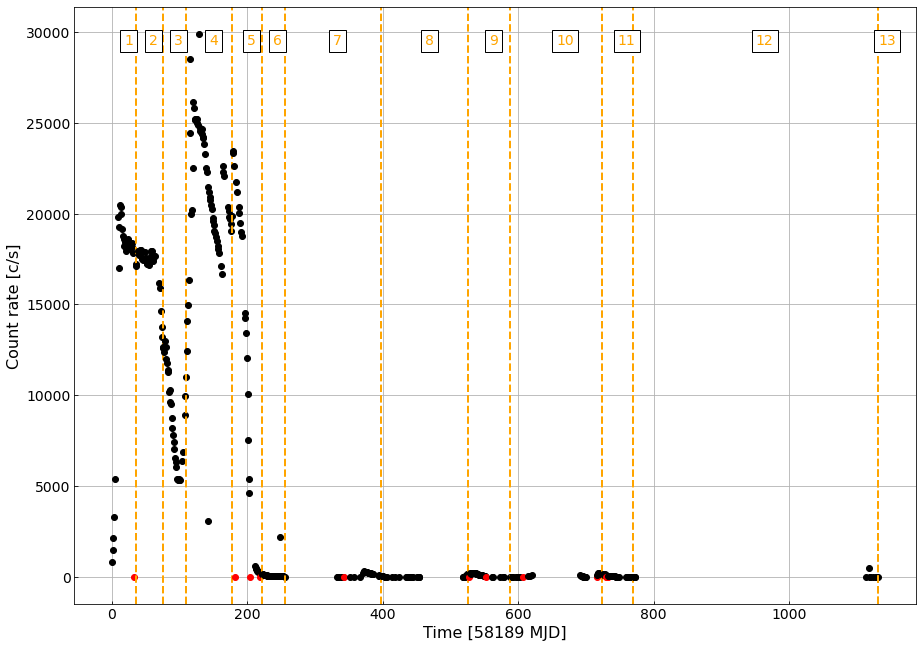

In [194]:
fig = plt.figure(figsize=(11.7,8.3))

ax1 = plt.axes([0.,0.,1.,1.])
max_y = np.max(info_obs_df['NAXIS2']/info_obs_df['ONTIME'])

counter = 1
for o in range(n_obs):
    
    obs_id = obs_ids[o]
    
    if info_obs_df.loc[obs_id]['TSTART'] == 0.: continue
        
    mjd_obs =convert_time(info_obs_df.loc[obs_id],info_obs_df.loc[obs_id]['TSTART'])-start_obs
    if o == 0:
        mjd_start = mjd_obs
    
    if info_obs_df.loc[obs_id]['ONTIME'] != 0:
        ax1.plot(mjd_obs,info_obs_df.loc[obs_id]['NAXIS2']/info_obs_df.loc[obs_id]['ONTIME'],'ok')
        bboxes += [dict(ec='black',fc='none')]
    else:
        ax1.plot(mjd_obs,0,'or')
        bboxes += [dict(ec='black',fc=(1., 0.8, 0.8))]
        
    if o in [chunk[-1] for chunk in obs_chunks]:
        ax1.axvline(mjd_obs,ls='--',color='orange',lw=2,zorder=2)
        
        mid_mjd = (mjd_start + mjd_obs)/2.
        ax1.text(mid_mjd,0.98*max_y,s=counter,fontsize=14,color='orange',label=counter,
                bbox=dict(ec='black',facecolor='white', alpha=1.0),zorder=3)
        
        counter += 1
        mjd_start = mjd_obs
        
    if o == n_obs - 1:
        ax1.axvline(mjd_obs,ls='--',color='orange',lw=2,zorder=2)
        
        mid_mjd = (mjd_start + mjd_obs)/2.
        ax1.text(mid_mjd,0.98*max_y,s=counter,fontsize=14,color='orange',label=counter,
                bbox=dict(ec='black',facecolor='white', alpha=1.0),zorder=3)        
        
ax1.grid()
ax1.set_xlabel('Time [{} MJD]'.format(start_obs),fontsize=16)
ax1.set_ylabel('Count rate [c/s]',fontsize=16)
ax1.tick_params('both',direction='in',labelsize=14)

fig.savefig('lc_obs_id_0.pdf',bbox_inches='tight',dpi=300)
lc_pdf_plots += ['lc_obs_id_0.pdf']
lc_pdf_labels += [f'full_lc ({obs_ids[0]}-{obs_ids[-1]})']


Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is in TT
Data Time is

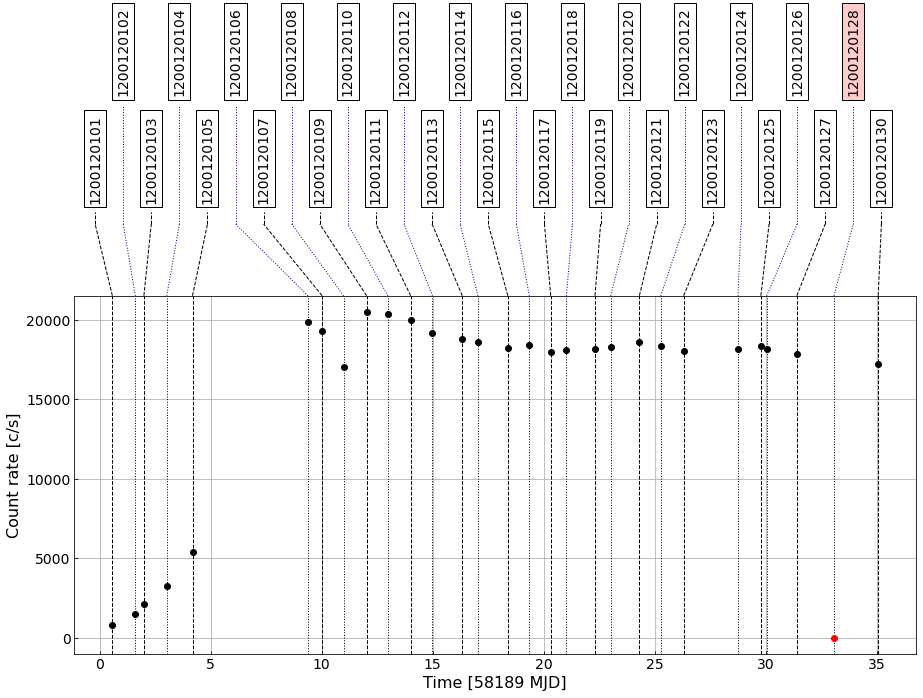

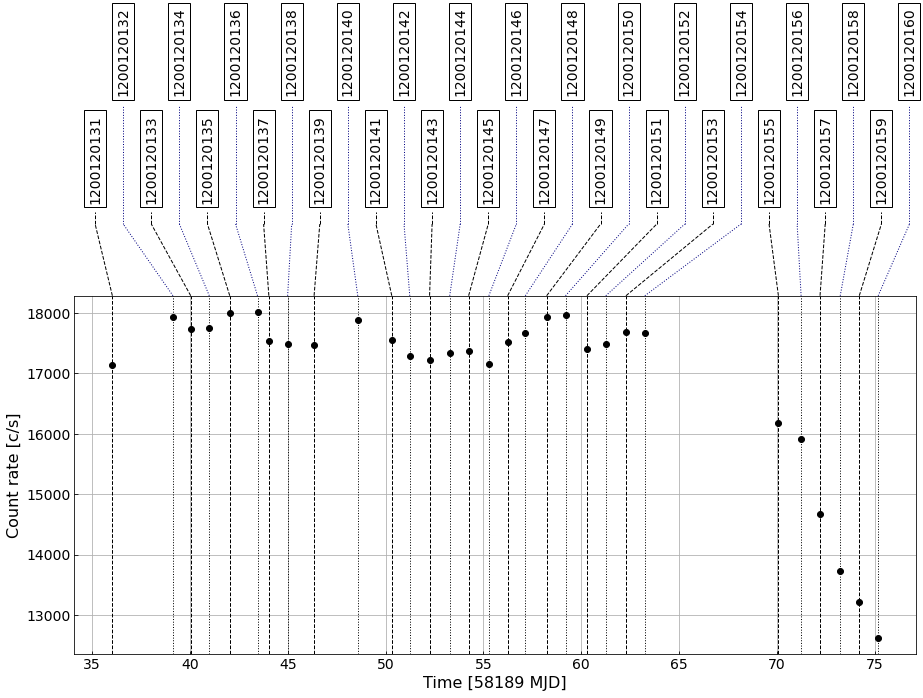

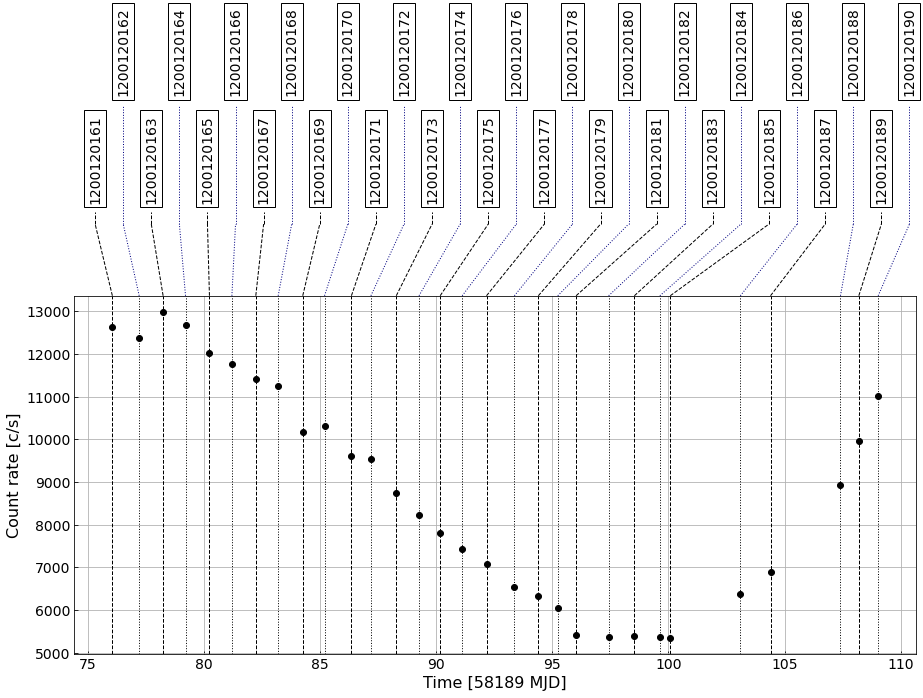

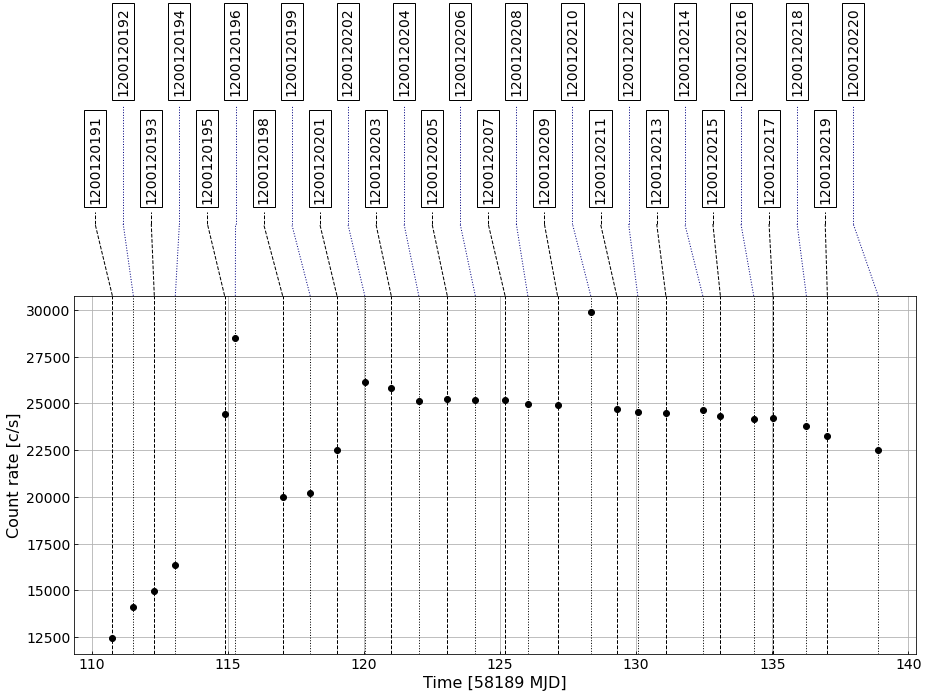

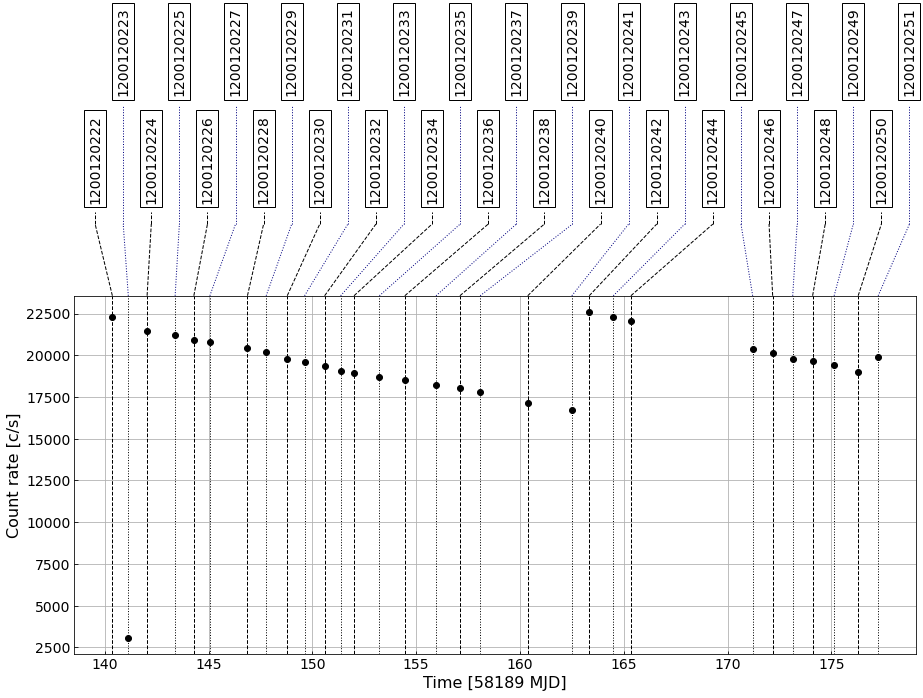

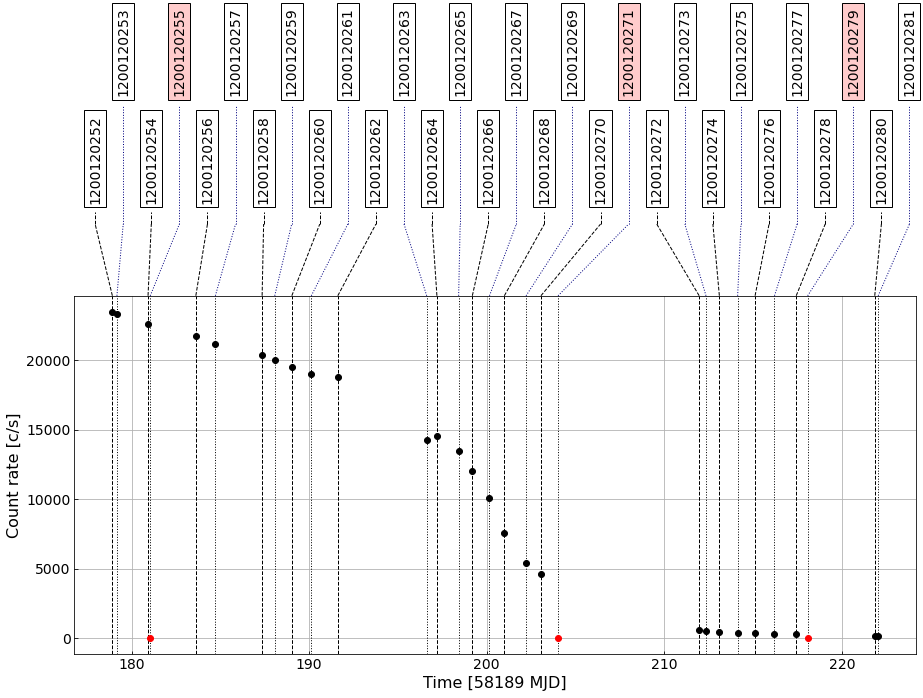

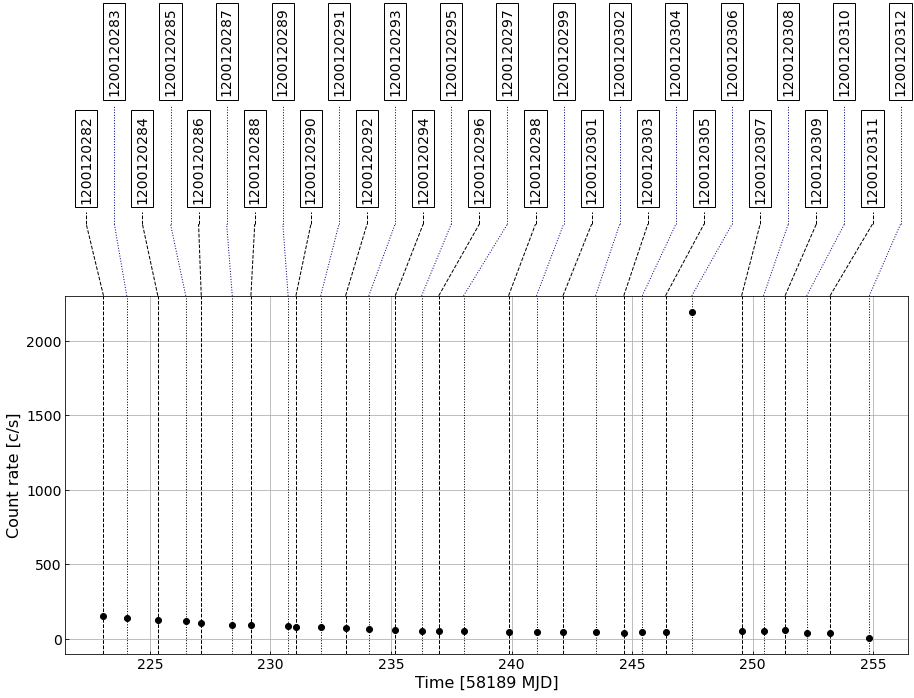

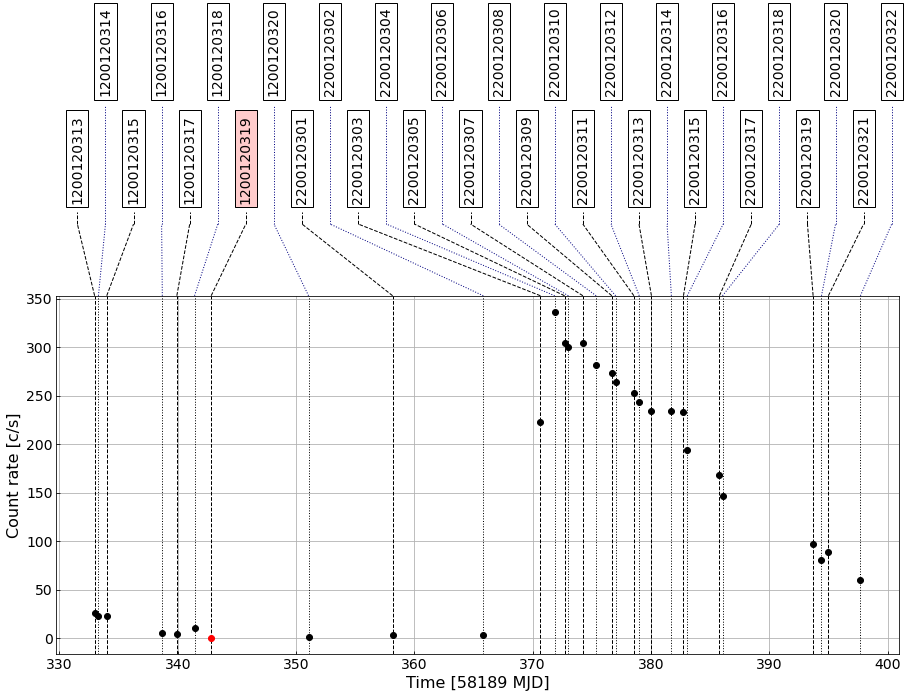

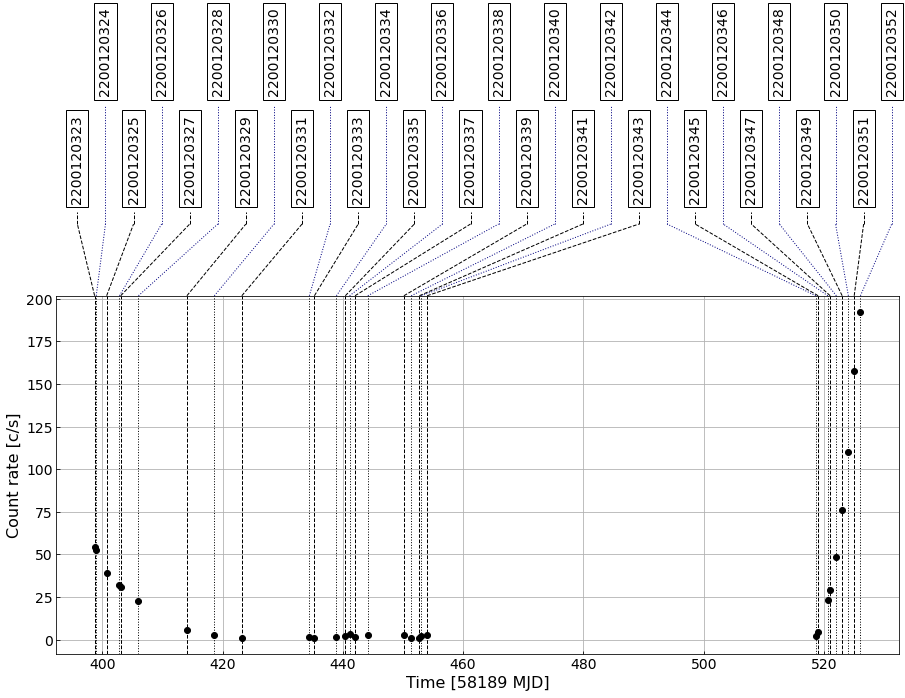

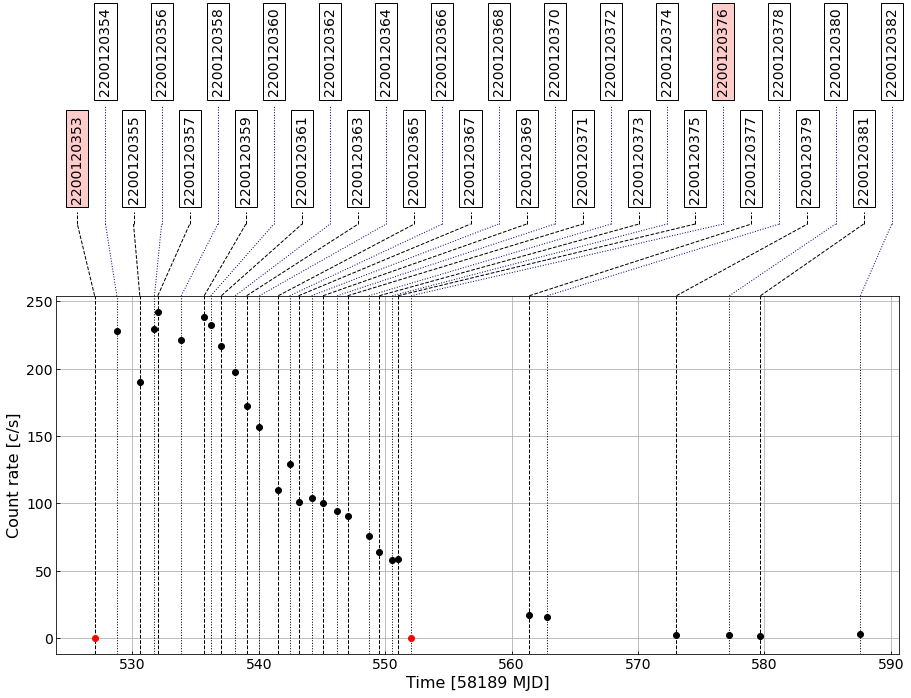

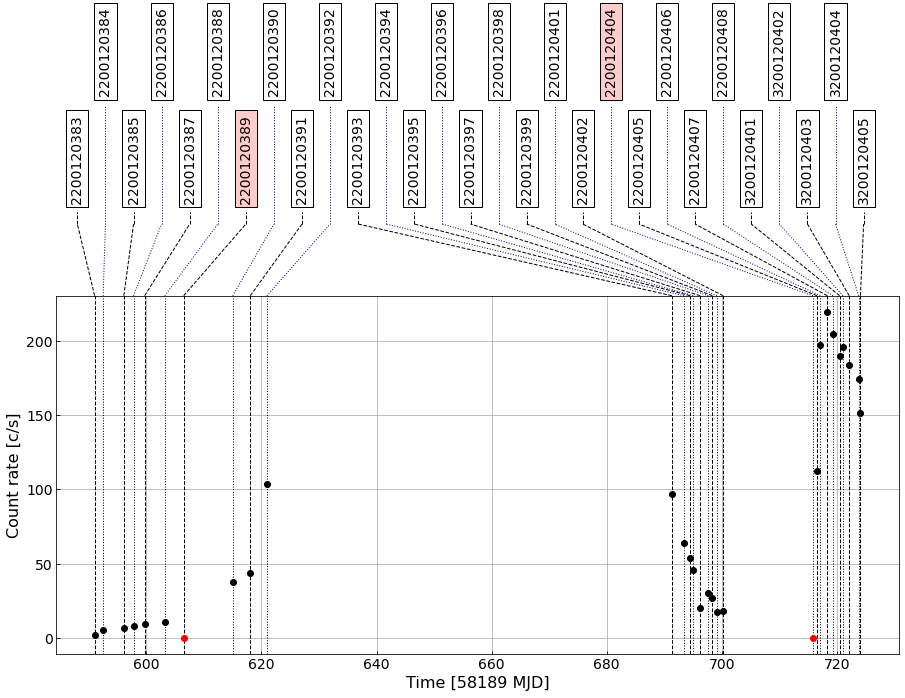

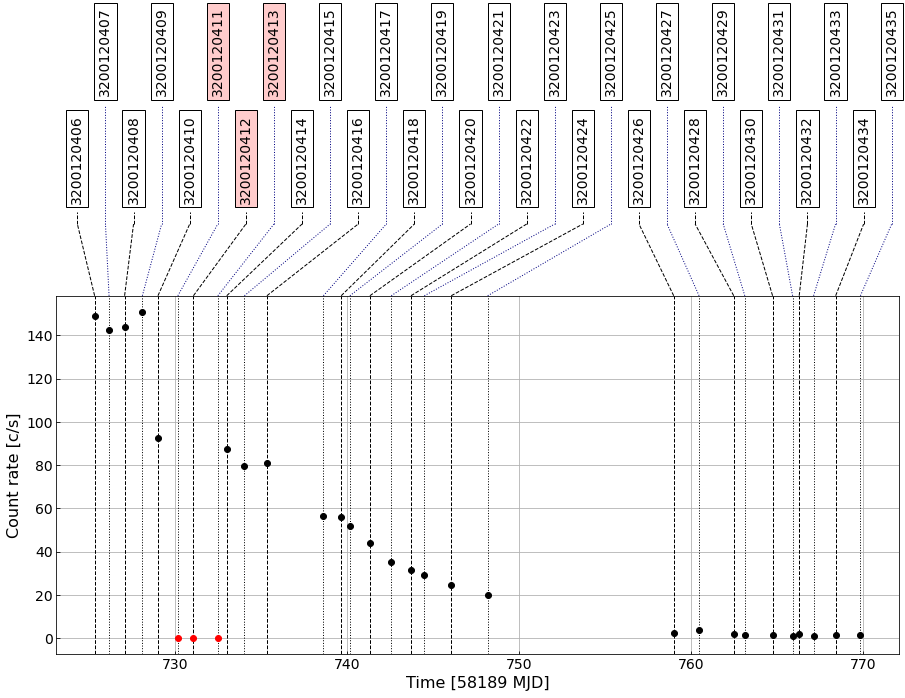

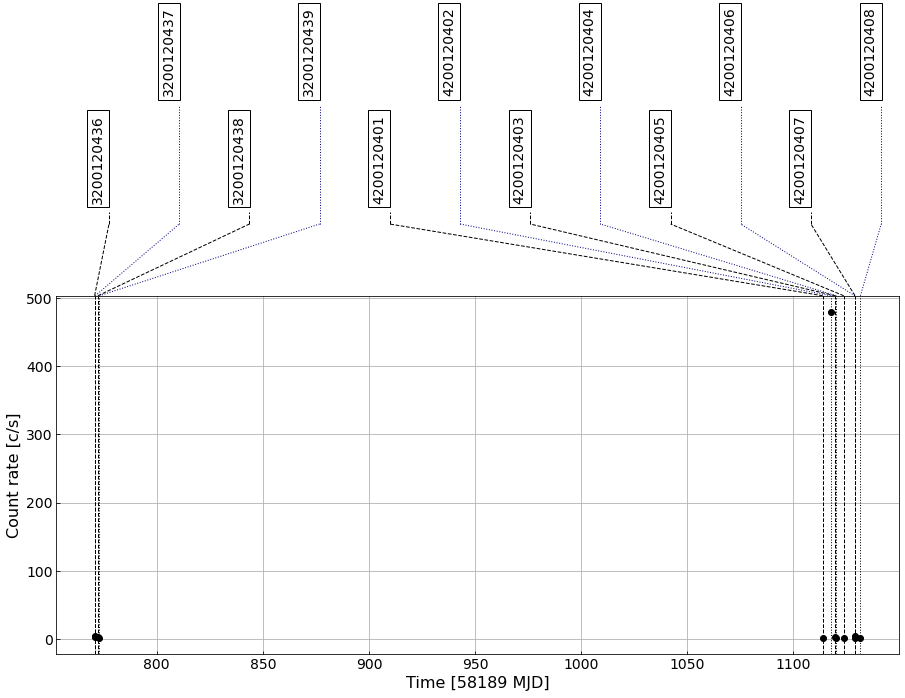

In [195]:
pdf_counter = 1

for chunk in obs_chunks:
    
    zoom = [0,0,0,0]
    fig = plt.figure(figsize=(11.7,8.3))
    #plt.subplots(constrained_layout=True)

    ax1 = plt.axes([0.,0.,1.,0.6]) # To make it 6 inches

    coors = []
    counter = 0
    bboxes = []
    for o in chunk:   

        obs_id = obs_ids[o]

        if counter %2 == 0 :
            ls = '--'
        else:
            ls = ':' 

        if info_obs_df.loc[obs_id]['TSTART'] == 0.: continue
        mjd_obs =convert_time(info_obs_df.loc[obs_id],info_obs_df.loc[obs_id]['TSTART'])-start_obs
        ax1.axvline(mjd_obs,ls=ls,color='k',lw=1)
        coors += [mjd_obs]
        counter+=1

        if zoom[1] and mjd_obs > zoom[1]:
            continue
        if zoom[0] and mjd_obs < zoom[0]:
            continue

        if info_obs_df.loc[obs_id]['ONTIME'] != 0:
            ax1.plot(mjd_obs,info_obs_df.loc[obs_id]['NAXIS2']/info_obs_df.loc[obs_id]['ONTIME'],'ok')
            bboxes += [dict(ec='black',fc='none')]
        else:
            ax1.plot(mjd_obs,0,'or')
            bboxes += [dict(ec='black',fc=(1., 0.8, 0.8))]

    zoomori = list(ax1.set_xlim())+list(ax1.set_ylim())
    newzoom = zoomori.copy()
    for z in range(len(zoom)):
        if zoom[z] != 0:
            newzoom[z] = zoom[z]
        else:
            newzoom[z] = zoomori[z]
    ax1.set_xlim([newzoom[0],newzoom[1]])
    ax1.set_ylim([newzoom[2],newzoom[3]])
    ax1.grid()
    ax1.set_xlabel('Time [{} MJD]'.format(start_obs),fontsize=16)
    ax1.set_ylabel('Count rate [c/s]',fontsize=16)
    ax1.tick_params('both',direction='in',labelsize=14)

    # Plotting obs_ID labels
    ax2 = plt.axes([0.,0.6,1.,0.4])

    start,stop = ax1.set_xlim()
    length = stop-start
    step = length/len(chunk)

    break_point = 0.3
    end_point1 = 0.35
    end_point2 = 0.8

    i = 0
    for o in chunk:
        obs_id = obs_ids[o]
        if info_obs_df.loc[obs_id]['TSTART'] == 0.:continue
        if coors[i] < newzoom[0] or coors[i] > newzoom[1]: continue

        if i%2 == 0:
            ls = 'k--'
            ax2.text(start+step/2+step*i,0.4,s=obs_ids[o],
                 fontsize=14,rotation=90,bbox=bboxes[i])
            ax2.plot([coors[i],start+step/2.+step*i + step/4.],[0,break_point],ls,lw=1)
            ax2.plot([start+step/2.+step*i + step/4.,start+step/2.+step*i + step/4.],[break_point,end_point1],ls,lw=1)
        else:
            ls = 'k:'
            ax2.text(start+step/2+step*i,0.85,s=obs_ids[o],
                 fontsize=14,rotation=90,bbox=bboxes[i])
            ax2.plot([coors[i],start+step/2.+step*i+step/4],[0,break_point],ls,lw=1,color='navy')
            ax2.plot([start+step/2.+step*i+step/4.,start+step/2.+step*i+step/4.],[break_point,end_point2],ls,lw=1,color='navy')
        #print('Processing obs {}'.format(info[o]['OBS_ID'][0]))

        #ax2.plot([start+step/2.+step*o,start+step/2.+step*o],[0.1,0.22],ls,lw=1)
        #ax2.text(start+step/2+step*o-step/6.,0.8,s=obs_ids[o],
        #         fontsize=14,rotation=90,bbox=bbox)

        i += 1

    ax2.set_ylim([0,1])
    ax2.set_xlim([newzoom[0],newzoom[1]])
    ax2.set_frame_on(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    fig.savefig(f'lc_obs_id_{pdf_counter}.pdf',bbox_inches='tight',dpi=300)

    lc_pdf_plots += [f'lc_obs_id_{pdf_counter}.pdf']
    lc_pdf_labels += [f'lc_sec{pdf_counter} ({obs_ids[chunk[0]]}-{obs_ids[chunk[-1]]})']
        
    pdf_counter +=1 

# Merging all the pdf files

In [196]:
pdf_plots = lc_pdf_plots + ['check_obs_df.pdf','info_obs_df.pdf','filter_obs_df.pdf']
pdf_labels = lc_pdf_labels + ['obs_files','basic_info','obs_filtering']

In [197]:
merger = PdfFileMerger()
for i,plot_to_add in enumerate(pdf_plots):
    merger.append(PdfFileReader(plot_to_add),bookmark=f'{pdf_labels[i]}')
merger.write('diagnostic.pdf')

In [184]:
from PyPDF4 import PdfFileWriter, PdfFileMerger, PdfFileReader 

# To manipulate the PDF dictionary
import PyPDF4.pdf as PDF

def add_nums(num_entry, page_offset, nums_array):
    for num in num_entry['/Nums']:
        if isinstance(num, (int)):
            print("Found page number %s, offset %s: ", num, page_offset)

            # Add the physical page information
            nums_array.append(PDF.NumberObject(num+page_offset))
        else:
            # {'/S': '/r'}, or {'/S': '/D', '/St': 489}
            keys = num.keys()
            print("Found page label, keys: %s", keys)
            number_type = PDF.DictionaryObject()
            # Always copy the /S entry
            s_entry = num['/S']
            number_type.update({PDF.NameObject("/S"): PDF.NameObject(s_entry)})
            print("Adding /S entry: %s", s_entry)

            if '/St' in keys:
                # If there is an /St entry, fetch it
                pdf_label_offset = num['/St']
                # and add the new offset to it
                print("Found /St %s", pdf_label_offset)
                number_type.update({PDF.NameObject("/St"): PDF.NumberObject(pdf_label_offset)})

            # Add the label information
            nums_array.append(number_type)

    return nums_array

def write_merged(pdf_readers):
    # Output
    merger = PdfFileMerger()

    # For PageLabels information
    page_labels = []
    page_offset = 0
    nums_array = PDF.ArrayObject()

    # Iterate through all the inputs
    for pdf_reader in pdf_readers:
        try:
            # Merge the content
            merger.append(pdf_reader)

            # Handle the PageLabels
            # Fetch page information
            old_page_labels = pdf_reader.trailer['/Root']['/PageLabels']
            page_count = pdf_reader.getNumPages()

            # Add PageLabel information
            add_nums(old_page_labels, page_offset, nums_array)
            page_offset = page_offset + page_count

        except Exception as err:
            print("ERROR: %s" % err)

    # Add PageLabels
    page_numbers = PDF.DictionaryObject()
    page_numbers.update({PDF.NameObject("/Nums"): nums_array})

    page_labels = PDF.DictionaryObject()
    page_labels.update({PDF.NameObject("/PageLabels"): page_numbers})

    root_obj = merger.output._root_object
    root_obj.update(page_labels)

    # Write output
    merger.write('diagnostic.pdf')


pdf_readers = []
for pdf_file in pdf_plots:
    tmp = PdfFileReader(pdf_file, 'rb')
    pdf_readers.append(tmp)

write_merged(pdf_readers)

ERROR: '/PageLabels'
ERROR: '/PageLabels'
ERROR: '/PageLabels'
ERROR: '/PageLabels'
